In [1]:
# coding=utf-8
from scapy.all import *
import binascii
import struct
import time

import crcmod
import libnum

from scapy.layers.inet import IP, UDP
from scapy.layers.l2 import Ether

import numpy as np

plc_cube = []
hmi_cube = []

def packet_analysis(pkt):
    if TCP in pkt:
        #print(pkt[TCP].dport)
        #print(len(pkt[TCP].payload))
        if len(pkt[TCP].payload) > 6:
            d_time = float(str(pkt.time))
            #print(type(d_time))
            #print(dir(pkt[TCP]))
            #print(pkt.summary())
            #print(pkt.time)
            #print(binascii.hexlify(bytes(pkt[TCP].payload))[12:])
            #print(type(float(pkt.time)))
            if(pkt[TCP].dport == 502):
                #plc_cube.append([d_time,binascii.hexlify(bytes(pkt[TCP].payload))[12:]])
                plc_cube.append(d_time)
            else:
                #hmi_cube.append([d_time,binascii.hexlify(bytes(pkt[TCP].payload))[12:]])
                hmi_cube.append(d_time)


In [2]:
try:
    #print(ifaces)
    #sniff(iface="Realtek PCIe GbE Family Controller", prn=packet_analysis, filter="udp port 18507")
    sniff(offline='DataSet/captures1_v2/captures1_v2/modbusQueryFlooding/eth2dump-modbusQueryFlooding1m-0,5h_1.pcap', prn=packet_analysis, store=0)
    plc_cube = np.asarray(plc_cube)
    hmi_cube = np.asarray(hmi_cube)
    print('Completed')

except Exception as sniff_dec_err:
    traceback.print_exc()
    print(str(sniff_dec_err))

Completed


In [3]:
print(hmi_cube.shape)
print(plc_cube.shape)

(3000,)
(3407,)


In [4]:
print(hmi_cube)

[1.52698695e+09 1.52698695e+09 1.52698696e+09 ... 1.52698874e+09
 1.52698875e+09 1.52698875e+09]


In [5]:
print(plc_cube)

[1.52698725e+09 1.52698725e+09 1.52698725e+09 ... 1.52698731e+09
 1.52698731e+09 1.52698731e+09]


In [6]:
fourier = np.fft.fft(hmi_cube)

In [7]:
timespan = hmi_cube[10] - hmi_cube[0]
print(timespan,'s')

28.980497121810913 s


In [8]:
hmi_diff = np.diff(hmi_cube)

In [9]:
print(hmi_diff)

[2.9014852  2.89862394 2.89029884 ... 2.89882302 2.90024114 2.89972901]


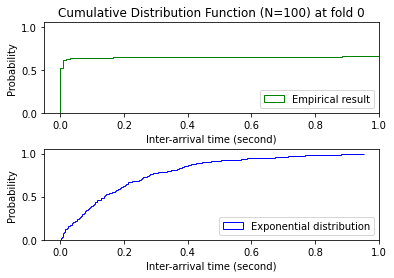

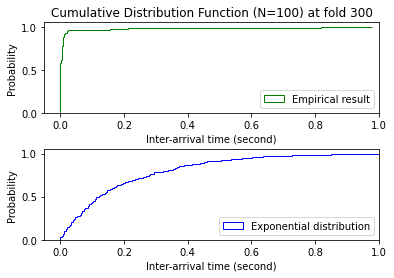

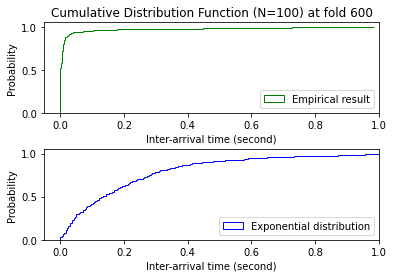

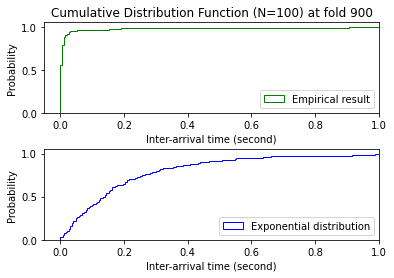

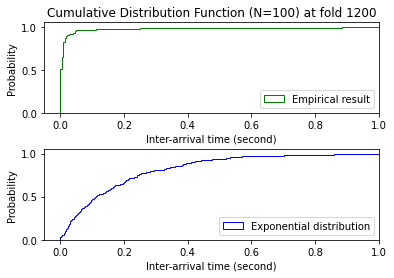

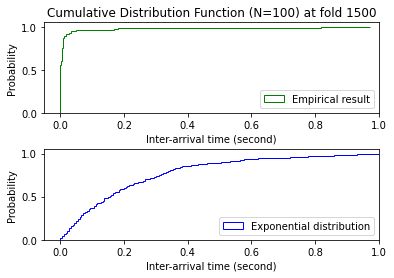

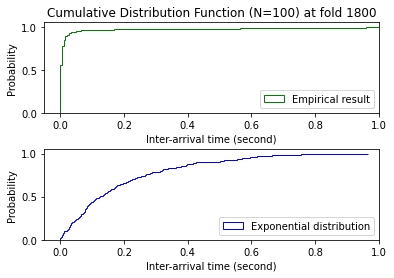

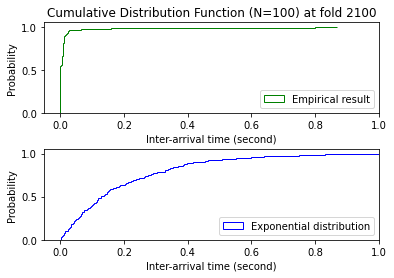

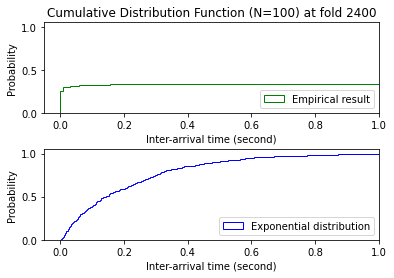

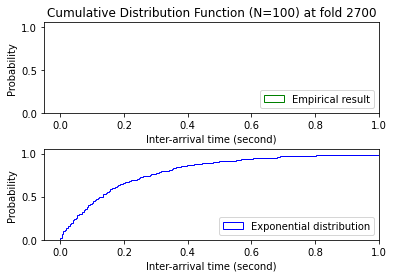

In [10]:

import numpy as np
import matplotlib.pyplot as plt

#fig1, ax = plt.subplots()
for k in range(10):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.subplots_adjust(hspace=0.4)

    #### First, plot the empirical result
    fold = k*300
    y = hmi_diff[fold:fold+300]
    n_bins = len(y)-1
    n, bins, patches = ax1.hist(y, n_bins, density=True, histtype='step',
              cumulative=True, label='Empirical result', color='g')
    # the following line is used to remove the last point
    patches[0].set_xy(patches[0].get_xy()[:-1])
    ax1.set_xlim(-0.05, 1.0)
    ax1.set_xlabel('Inter-arrival time (second)')
    ax1.set_ylabel('Probability')
    ax1.set_title('Cumulative Distribution Function (N=100) at fold ' + str(fold))
    ax1.legend(loc=4)

    #### Then plot the theoretical expontential distribution
    G = np.random.default_rng()
    y = G.exponential(scale=0.2, size=len(y))
    # Now, plot the cumulative distributioin function (CDF)
    n_bins = len(y)-1
    n, bins, patches = ax2.hist(y, n_bins, density=True, histtype='step',
              cumulative=True, label='Exponential distribution', color='b')
    # the following line is used to remove the last point
    patches[0].set_xy(patches[0].get_xy()[:-1])
    ax2.set_xlim(-0.05, 1.0)
    ax2.set_xlabel('Inter-arrival time (second)')
    ax2.set_ylabel('Probability')
    #ax2.set_title('Cumulative Distribution Function (N=100)')
    ax2.legend(loc=4)

plt.show()
#plt.savefig('./cdf.pdf')

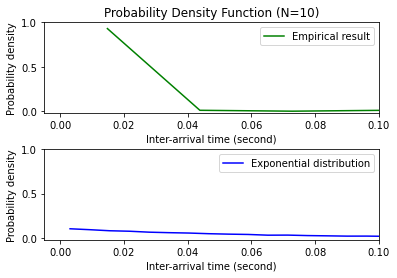

In [11]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.4)

#### First, plot the p.d.f. of our empirical result
y = hmi_diff[100:200]
heights, bins = np.histogram(y, bins=100)
# do normalization
heights = heights/float(sum(heights))
binMids = bins[:-1]+np.diff(bins)/2.
ax1.plot(binMids, heights, label='Empirical result', color='g')
ax1.set_xlim(-0.005, 0.1)
ax1.set_ylim(-0.02, 1.0)
ax1.set_xlabel('Inter-arrival time (second)')
ax1.set_ylabel('Probability density')
ax1.set_title('Probability Density Function (N=10)')
ax1.legend(loc=1)

#### Now, plot the p.d.f. of exponential distribution
G = np.random.default_rng()
y = G.exponential(scale=0.055, size=9010)
heights, bins = np.histogram(y, bins=100)
# do normalization
heights = heights/float(sum(heights))
binMids = bins[:-1]+np.diff(bins)/2.
ax2.plot(binMids, heights, label='Exponential distribution', color='b')
ax2.set_xlim(-0.005, 0.1)
ax2.set_ylim(-0.02, 1.0)
ax2.set_xlabel('Inter-arrival time (second)')
ax2.set_ylabel('Probability density')
ax2.legend(loc=1)

plt.show()


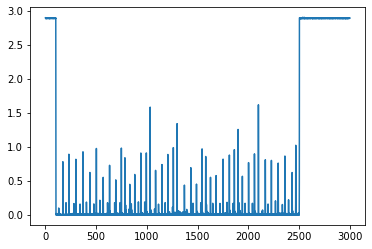

In [12]:
plt.plot(hmi_diff)
plt.show()

In [13]:
freqs = np.fft.fftfreq(len(hmi_diff))

In [14]:
for coef,freq in zip(fourier,freqs):
    if coef:
        print('{c:>6} * exp(2 pi i t * {f})'.format(c=coef,f=freq))

(4580962187398.96+0j) * exp(2 pi i t * 0.0)
(309404.4355593503+155439.2236745067j) * exp(2 pi i t * 0.00033344448149383126)
(229085.7690722461+219398.8592644425j) * exp(2 pi i t * 0.0006668889629876625)
(130449.39840783097+241592.41698886338j) * exp(2 pi i t * 0.0010003334444814937)
(46779.57457587223+219115.90316489633j) * exp(2 pi i t * 0.001333777925975325)
(-1312.449894725772+171846.3425795667j) * exp(2 pi i t * 0.0016672224074691564)
(-14103.807514520651+126167.12338966563j) * exp(2 pi i t * 0.0020006668889629873)
(-6885.335935666404+98149.28216705268j) * exp(2 pi i t * 0.0023341113704568187)
(2327.300481999853+88269.74140728038j) * exp(2 pi i t * 0.00266755585195065)
(4300.433749135111+87747.95127696943j) * exp(2 pi i t * 0.0030010003334444814)
(-1288.7018819662462+86113.64009242816j) * exp(2 pi i t * 0.003334444814938313)
(-6949.0129205667035+79156.55927386254j) * exp(2 pi i t * 0.0036678892964321437)
(-9501.67780066716+69396.70179680381j) * exp(2 pi i t * 0.004001333777925975)


(-964.2702529355211+5380.608722289425j) * exp(2 pi i t * 0.05268422807602534)
(-869.0133590887415+5324.010278368736j) * exp(2 pi i t * 0.05301767255751917)
(-912.6376866871399+5327.954224984184j) * exp(2 pi i t * 0.053351117039013005)
(-922.5907885976271+5338.452508273746j) * exp(2 pi i t * 0.05368456152050683)
(-961.5397727543407+5283.852608893865j) * exp(2 pi i t * 0.054018006002000664)
(-949.7159589801311+5215.2327233106025j) * exp(2 pi i t * 0.0543514504834945)
(-912.6778340693046+5187.91776857377j) * exp(2 pi i t * 0.05468489496498832)
(-891.7352326767234+5189.448078315158j) * exp(2 pi i t * 0.055018339446482156)
(-890.272478297192+5158.085614135885j) * exp(2 pi i t * 0.05535178392797599)
(-884.0578890716765+5156.5285286137j) * exp(2 pi i t * 0.05568522840946982)
(-915.7764753407262+5116.426102783921j) * exp(2 pi i t * 0.05601867289096365)
(-910.6737506357002+4998.552791704086j) * exp(2 pi i t * 0.05635211737245748)
(-893.5036202082899+5024.430624069049j) * exp(2 pi i t * 0.056685

(-903.9336129721728+2208.1681629952823j) * exp(2 pi i t * 0.12404134711570523)
(-909.833683369749+2193.103104148984j) * exp(2 pi i t * 0.12437479159719905)
(-891.9242321457515+2187.5956287010777j) * exp(2 pi i t * 0.12470823607869289)
(-897.0724501394097+2175.4074907020276j) * exp(2 pi i t * 0.12504168056018672)
(-892.095224361229+2162.18507697868j) * exp(2 pi i t * 0.12537512504168055)
(-892.0268365259603+2166.0465445800155j) * exp(2 pi i t * 0.12570856952317438)
(-894.6183073043294+2167.528229149696j) * exp(2 pi i t * 0.12604201400466822)
(-900.7575684207136+2141.6820561958784j) * exp(2 pi i t * 0.12637545848616205)
(-892.1999538213656+2138.65836251025j) * exp(2 pi i t * 0.12670890296765588)
(-904.0347030603306+2130.2844175292294j) * exp(2 pi i t * 0.12704234744914972)
(-896.6211922997516+2124.9788349209166j) * exp(2 pi i t * 0.12737579193064355)
(-886.1351054861134+2121.6874129359658j) * exp(2 pi i t * 0.12770923641213738)
(-910.22193449772+2113.267375274559j) * exp(2 pi i t * 0.128

(-902.7088216194222+1455.874530529918j) * exp(2 pi i t * 0.1760586862287429)
(-901.7323208715251+1457.0755999870812j) * exp(2 pi i t * 0.17639213071023674)
(-899.9445345205087+1451.3540187729604j) * exp(2 pi i t * 0.17672557519173057)
(-898.8624133702313+1450.1047790585208j) * exp(2 pi i t * 0.1770590196732244)
(-901.4491068306152+1434.3800438551734j) * exp(2 pi i t * 0.17739246415471824)
(-898.9880857498808+1439.1238416398114j) * exp(2 pi i t * 0.17772590863621207)
(-902.5910887756013+1442.4895286253532j) * exp(2 pi i t * 0.1780593531177059)
(-906.4707463332263+1436.5963122884405j) * exp(2 pi i t * 0.1783927975991997)
(-897.7446811208779+1427.927839560432j) * exp(2 pi i t * 0.17872624208069354)
(-907.0927304127202+1429.2567498697626j) * exp(2 pi i t * 0.17905968656218738)
(-904.5010567415416+1424.5832107020337j) * exp(2 pi i t * 0.1793931310436812)
(-902.7624197870568+1424.8900842248468j) * exp(2 pi i t * 0.17972657552517504)
(-891.7553766911841+1417.4475308313977j) * exp(2 pi i t * 0

(-900.6454540339539+1091.3282379024834j) * exp(2 pi i t * 0.21907302434144713)
(-905.2199869479444+1095.0530622888818j) * exp(2 pi i t * 0.21940646882294096)
(-898.8429977333345+1084.7344248532545j) * exp(2 pi i t * 0.2197399133044348)
(-896.006287644704+1093.1299049176287j) * exp(2 pi i t * 0.22007335778592862)
(-902.8801859276789+1091.025200075514j) * exp(2 pi i t * 0.22040680226742246)
(-906.4775247792742+1084.9465739208283j) * exp(2 pi i t * 0.2207402467489163)
(-896.4651835703555+1079.8187837397693j) * exp(2 pi i t * 0.22107369123041012)
(-905.7783575583727+1076.4654144674819j) * exp(2 pi i t * 0.22140713571190396)
(-898.1178577990019+1079.9732852816874j) * exp(2 pi i t * 0.2217405801933978)
(-899.8136785527525+1076.7950687475984j) * exp(2 pi i t * 0.22207402467489162)
(-901.9868232238072+1077.9439730325703j) * exp(2 pi i t * 0.22240746915638546)
(-895.304843168742+1076.328840340911j) * exp(2 pi i t * 0.2227409136378793)
(-906.2657743112445+1064.9236838165348j) * exp(2 pi i t * 0.

(-900.5740635391476+694.3279161066217j) * exp(2 pi i t * 0.2897632544181394)
(-900.1752354537792+701.4515401957874j) * exp(2 pi i t * 0.2900966988996332)
(-903.8872649194756+697.1746059562073j) * exp(2 pi i t * 0.29043014338112705)
(-896.555079789803+694.3569390567493j) * exp(2 pi i t * 0.29076358786262085)
(-900.2508108324373+699.7163528313827j) * exp(2 pi i t * 0.2910970323441147)
(-904.3792436725336+688.9552275481003j) * exp(2 pi i t * 0.2914304768256085)
(-899.595229906573+691.081474518217j) * exp(2 pi i t * 0.2917639213071023)
(-897.259413167672+691.950324348131j) * exp(2 pi i t * 0.2920973657885962)
(-897.4438830425079+687.1934171109167j) * exp(2 pi i t * 0.29243081027009)
(-901.4533714888795+683.2065658728663j) * exp(2 pi i t * 0.29276425475158385)
(-903.3843508978971+689.4013712874201j) * exp(2 pi i t * 0.29309769923307766)
(-897.0699715014216+682.6622507094829j) * exp(2 pi i t * 0.2934311437145715)
(-900.4954677313794+677.7509253073649j) * exp(2 pi i t * 0.2937645881960653)
(-

(-898.879132160731+534.5386538174737j) * exp(2 pi i t * 0.3284428142714238)
(-897.5875318859469+537.2132140722504j) * exp(2 pi i t * 0.3287762587529176)
(-899.9613484924128+541.5204129020933j) * exp(2 pi i t * 0.32910970323441147)
(-906.1527716397422+533.9697655341192j) * exp(2 pi i t * 0.32944314771590527)
(-896.7545470543411+531.2980446769518j) * exp(2 pi i t * 0.32977659219739913)
(-899.0666031044357+531.6927003098326j) * exp(2 pi i t * 0.33011003667889294)
(-899.7928451662445+532.7572227820604j) * exp(2 pi i t * 0.3304434811603868)
(-899.6852555345492+528.2040740273428j) * exp(2 pi i t * 0.3307769256418806)
(-903.97196027843+531.9621287234727j) * exp(2 pi i t * 0.33111037012337446)
(-898.5757194115372+526.8977940583268j) * exp(2 pi i t * 0.33144381460486827)
(-898.3542855382981+524.1667394707783j) * exp(2 pi i t * 0.3317772590863621)
(-901.1891345747591+523.8844244447505j) * exp(2 pi i t * 0.33211070356785594)
(-899.2418895051428+520.9891783726976j) * exp(2 pi i t * 0.3324441480493

(-898.5607939982901+368.23341866028477j) * exp(2 pi i t * 0.3767922640880293)
(-903.7483206213861+367.0101131326637j) * exp(2 pi i t * 0.37712570856952315)
(-900.1493384439183+371.5481178084483j) * exp(2 pi i t * 0.37745915305101696)
(-898.9255128254919+359.809018684271j) * exp(2 pi i t * 0.3777925975325108)
(-899.6934528847415+363.6794998151672j) * exp(2 pi i t * 0.3781260420140046)
(-901.9336041310662+361.54008249433355j) * exp(2 pi i t * 0.3784594864954985)
(-899.1162340558133+362.0315867408881j) * exp(2 pi i t * 0.3787929309769923)
(-900.2668460752571+362.3600628375534j) * exp(2 pi i t * 0.37912637545848615)
(-899.8734960238322+356.69968953074294j) * exp(2 pi i t * 0.37945981993997996)
(-898.1327734741794+355.75167715307634j) * exp(2 pi i t * 0.3797932644214738)
(-902.4527799492387+360.02905629016095j) * exp(2 pi i t * 0.3801267089029676)
(-899.428527897956+352.19123372570994j) * exp(2 pi i t * 0.3804601533844615)
(-899.552778438132+349.7835084874687j) * exp(2 pi i t * 0.3807935978

(-902.0260861262004+201.21994124182078j) * exp(2 pi i t * 0.43114371457152384)
(-899.016656110036+197.3284990139996j) * exp(2 pi i t * 0.43147715905301764)
(-901.0272108004475+194.56083306922983j) * exp(2 pi i t * 0.4318106035345115)
(-902.2698897905528+194.03269787392418j) * exp(2 pi i t * 0.4321440480160053)
(-900.8691250161602+195.6297144720656j) * exp(2 pi i t * 0.4324774924974991)
(-901.5535183483469+193.5595405589022j) * exp(2 pi i t * 0.432810936978993)
(-901.0558379229507+190.1320088600911j) * exp(2 pi i t * 0.4331443814604868)
(-900.4055708289611+195.75974933164872j) * exp(2 pi i t * 0.43347782594198064)
(-902.1430998611081+190.6581839517882j) * exp(2 pi i t * 0.43381127042347445)
(-899.629871105911+187.58096328672337j) * exp(2 pi i t * 0.4341447149049683)
(-902.7149821273432+191.8686306701557j) * exp(2 pi i t * 0.4344781593864621)
(-899.8511998007774+186.2776145223499j) * exp(2 pi i t * 0.434811603867956)
(-897.5246462486717+189.3195519442399j) * exp(2 pi i t * 0.435145048349

(-899.2145348472781+52.68326521625505j) * exp(2 pi i t * 0.48149383127709233)
(-901.7153072834335+52.057932258526705j) * exp(2 pi i t * 0.4818272757585862)
(-901.627682195079+55.41250228395535j) * exp(2 pi i t * 0.48216072024008)
(-900.5753030385838+47.15538765868217j) * exp(2 pi i t * 0.4824941647215738)
(-901.0387322958439+48.162887806003766j) * exp(2 pi i t * 0.48282760920306766)
(-897.9070794724723+52.38919315153839j) * exp(2 pi i t * 0.48316105368456147)
(-901.9654789957855+45.155962419739296j) * exp(2 pi i t * 0.48349449816605533)
(-901.8049179578014+46.41168886687967j) * exp(2 pi i t * 0.48382794264754914)
(-902.0661943253153+43.86515602272027j) * exp(2 pi i t * 0.484161387129043)
(-900.2525795235503+50.17964000347206j) * exp(2 pi i t * 0.4844948316105368)
(-900.4419153861069+43.117937753921865j) * exp(2 pi i t * 0.48482827609203066)
(-897.2414746845127+41.98945183000234j) * exp(2 pi i t * 0.48516172057352447)
(-898.2804669744537+44.63683639165737j) * exp(2 pi i t * 0.4854951650

(-906.6263342378838-197.72147467863533j) * exp(2 pi i t * -0.4301433811270423)
(-900.730775361583-201.83021440486414j) * exp(2 pi i t * -0.4298099366455485)
(-899.0403930492772-203.99178300453855j) * exp(2 pi i t * -0.42947649216405465)
(-904.140753915443-197.29350128647275j) * exp(2 pi i t * -0.42914304768256084)
(-898.6997008902908-206.39669069506j) * exp(2 pi i t * -0.428809603201067)
(-900.7586063842797-203.85663229537408j) * exp(2 pi i t * -0.4284761587195732)
(-899.2714353510767-203.8637776335538j) * exp(2 pi i t * -0.4281427142380793)
(-898.7108460077786-207.9912707929857j) * exp(2 pi i t * -0.4278092697565855)
(-900.6838622099053-207.21654662524134j) * exp(2 pi i t * -0.42747582527509165)
(-900.7831720839581-210.59114317883837j) * exp(2 pi i t * -0.42714238079359784)
(-899.1758632158171-210.08272852412915j) * exp(2 pi i t * -0.42680893631210404)
(-900.1668530712597-211.5065044604512j) * exp(2 pi i t * -0.4264754918306102)
(-900.6829187290059-211.52024374043208j) * exp(2 pi i t 

(-902.7146119223563-352.22515137926985j) * exp(2 pi i t * -0.38112704234744915)
(-901.6665925801414-356.37034963068754j) * exp(2 pi i t * -0.3807935978659553)
(-899.5527784381314-349.78350848746766j) * exp(2 pi i t * -0.3804601533844615)
(-899.4285278979538-352.1912337257122j) * exp(2 pi i t * -0.3801267089029676)
(-902.4527799492382-360.02905629016374j) * exp(2 pi i t * -0.3797932644214738)
(-898.1327734741802-355.7516771530783j) * exp(2 pi i t * -0.37945981993997996)
(-899.8734960238347-356.69968953074635j) * exp(2 pi i t * -0.37912637545848615)
(-900.2668460752589-362.3600628375514j) * exp(2 pi i t * -0.3787929309769923)
(-899.1162340558126-362.03158674089j) * exp(2 pi i t * -0.3784594864954985)
(-901.9336041310648-361.54008249433144j) * exp(2 pi i t * -0.3781260420140046)
(-899.6934528847441-363.67949981516654j) * exp(2 pi i t * -0.3777925975325108)
(-898.9255128254891-359.80901868426935j) * exp(2 pi i t * -0.37745915305101696)
(-900.1493384439186-371.54811780844886j) * exp(2 pi i 

(-901.3292071620174-511.7799909662698j) * exp(2 pi i t * -0.33644548182727574)
(-898.8138613628654-511.4069050734315j) * exp(2 pi i t * -0.33611203734578193)
(-899.7037989836525-506.7060248290136j) * exp(2 pi i t * -0.3357785928642881)
(-901.3868839155878-511.89482730255673j) * exp(2 pi i t * -0.33544514838279427)
(-901.392238171861-512.7160988978496j) * exp(2 pi i t * -0.3351117039013004)
(-901.5850378262445-511.6881505442624j) * exp(2 pi i t * -0.3347782594198066)
(-901.9242431630527-519.7688197349026j) * exp(2 pi i t * -0.33444481493831274)
(-900.2374355973985-517.6156388234517j) * exp(2 pi i t * -0.33411137045681893)
(-899.7599029127571-515.2005694512128j) * exp(2 pi i t * -0.3337779259753251)
(-901.0735074677871-515.4458002612962j) * exp(2 pi i t * -0.33344448149383127)
(-905.711414337158-523.1046496513068j) * exp(2 pi i t * -0.3331110370123374)
(-900.5814561451039-519.1454391107291j) * exp(2 pi i t * -0.3327775925308436)
(-900.9340401619862-523.051223822715j) * exp(2 pi i t * -0.

(-899.7206617581306-746.3219292050982j) * exp(2 pi i t * -0.28009336445481825)
(-899.77419031996-749.3781654438318j) * exp(2 pi i t * -0.27975991997332444)
(-893.8866029771998-745.0451428297883j) * exp(2 pi i t * -0.2794264754918306)
(-903.7953163675229-745.0080551455953j) * exp(2 pi i t * -0.2790930310103368)
(-902.1979942950826-755.1159614647968j) * exp(2 pi i t * -0.2787595865288429)
(-901.8783940661884-753.0319670194572j) * exp(2 pi i t * -0.2784261420473491)
(-901.9121942788031-753.9670325708572j) * exp(2 pi i t * -0.27809269756585525)
(-898.673125758899-756.1390097244541j) * exp(2 pi i t * -0.27775925308436145)
(-898.2838948246329-755.1641455328456j) * exp(2 pi i t * -0.2774258086028676)
(-904.2997250479759-757.970211619383j) * exp(2 pi i t * -0.2770923641213738)
(-906.2750571336995-761.0332162460296j) * exp(2 pi i t * -0.2767589196398799)
(-900.5385198832242-760.5332692451838j) * exp(2 pi i t * -0.2764254751583861)
(-901.0496716453489-764.62033749758j) * exp(2 pi i t * -0.276092

(-899.2841251280666-1039.8872748247036j) * exp(2 pi i t * -0.22640880293431143)
(-906.713806926992-1040.5179588461713j) * exp(2 pi i t * -0.2260753584528176)
(-900.3875758026566-1048.430348223845j) * exp(2 pi i t * -0.22574191397132376)
(-898.146903879618-1049.7149540487633j) * exp(2 pi i t * -0.22540846948982993)
(-893.9290435891863-1050.4044317716941j) * exp(2 pi i t * -0.2250750250083361)
(-906.2688703969942-1049.5359783254514j) * exp(2 pi i t * -0.22474158052684226)
(-901.1755446365216-1053.231433903726j) * exp(2 pi i t * -0.22440813604534843)
(-896.3670126073026-1059.636536534515j) * exp(2 pi i t * -0.2240746915638546)
(-899.4278616832015-1066.1096159237145j) * exp(2 pi i t * -0.22374124708236076)
(-898.2520239618891-1062.6167796609122j) * exp(2 pi i t * -0.22340780260086696)
(-892.8951732111494-1060.936766086246j) * exp(2 pi i t * -0.22307435811937312)
(-906.2657743112406-1064.9236838165375j) * exp(2 pi i t * -0.2227409136378793)
(-895.3048431687434-1076.3288403409124j) * exp(2 p

(-892.1999538213659-2138.6583625102494j) * exp(2 pi i t * -0.12637545848616205)
(-900.7575684207166-2141.6820561958807j) * exp(2 pi i t * -0.12604201400466822)
(-894.6183073043269-2167.5282291496937j) * exp(2 pi i t * -0.12570856952317438)
(-892.026836525957-2166.046544580013j) * exp(2 pi i t * -0.12537512504168055)
(-892.0952243612309-2162.18507697868j) * exp(2 pi i t * -0.12504168056018672)
(-897.0724501394042-2175.407490702025j) * exp(2 pi i t * -0.12470823607869289)
(-891.9242321457467-2187.5956287010763j) * exp(2 pi i t * -0.12437479159719905)
(-909.833683369747-2193.103104148984j) * exp(2 pi i t * -0.12404134711570523)
(-903.9336129721709-2208.1681629952823j) * exp(2 pi i t * -0.1237079026342114)
(-898.8936148656194-2203.652741786117j) * exp(2 pi i t * -0.12337445815271757)
(-890.7511970042657-2210.924498064015j) * exp(2 pi i t * -0.12304101367122373)
(-910.9232532255882-2207.5773238270517j) * exp(2 pi i t * -0.1227075691897299)
(-905.6258891077887-2223.170782669815j) * exp(2 pi 

(-894.0577257789704-3742.0704559429114j) * exp(2 pi i t * -0.07535845281760586)
(-872.6148345099946-3727.450360654675j) * exp(2 pi i t * -0.07502500833611203)
(-896.5765655831982-3769.7243333702436j) * exp(2 pi i t * -0.0746915638546182)
(-912.3901220106713-3760.85007286323j) * exp(2 pi i t * -0.07435811937312437)
(-918.1964189743147-3803.374060698772j) * exp(2 pi i t * -0.07402467489163055)
(-933.5645362092987-3836.2637215612376j) * exp(2 pi i t * -0.07369123041013671)
(-896.7205317472307-3830.770463927155j) * exp(2 pi i t * -0.07335778592864288)
(-904.2697623413628-3829.4953325170245j) * exp(2 pi i t * -0.07302434144714905)
(-901.6779967104735-3853.199866091705j) * exp(2 pi i t * -0.07269089696565521)
(-918.9424264186208-3867.5984511837087j) * exp(2 pi i t * -0.07235745248416138)
(-911.7488420920743-3891.3381910884054j) * exp(2 pi i t * -0.07202400800266755)
(-922.1192517637213-3914.1816747971443j) * exp(2 pi i t * -0.07169056352117371)
(-916.4283992132149-3948.7051949366014j) * exp(

(-658.958234119896-13442.409908864018j) * exp(2 pi i t * -0.020673557852617538)
(-759.0891729740928-13596.917996699369j) * exp(2 pi i t * -0.020340113371123708)
(-884.265336602982-13819.641615683478j) * exp(2 pi i t * -0.020006668889629875)
(-857.7243877515118-14258.420210659064j) * exp(2 pi i t * -0.019673224408136045)
(-800.652759414013-14808.037218983143j) * exp(2 pi i t * -0.019339779926642212)
(-566.143349826054-14955.9197864716j) * exp(2 pi i t * -0.019006335445148383)
(-499.4060637382461-15013.261856652003j) * exp(2 pi i t * -0.01867289096365455)
(-656.2610190198453-15314.814473434551j) * exp(2 pi i t * -0.01833944648216072)
(-915.4946782394859-15555.717740132584j) * exp(2 pi i t * -0.018006002000666887)
(-980.4554558709308-16165.677490477423j) * exp(2 pi i t * -0.017672557519173057)
(-921.7448236671826-16623.191627066015j) * exp(2 pi i t * -0.017339113037679224)
(-639.8004941693655-16927.64045358678j) * exp(2 pi i t * -0.017005668556185394)
(-614.0176894941033-17040.06126582349